In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
#import torch.cuda
import random
from itertools import chain as chain
from torch.distributions.multivariate_normal import MultivariateNormal

#conda activate base
cudaOn = False

In [2]:
tepLoc = "C:/Users/Charlie/Desktop/TEP_Data/"
tepTrain = tepLoc + "TEP_Faulty_Training.csv"
tepTrain2 = tepLoc + "TEP_FaultFree_Training.csv"
#tepTest = tepLoc + "TEP_FaultFree_Testing.csv"
tepTest = tepLoc + "TEP_Faulty_Testing.csv"
#tepTrain = '/content/TEP_Faulty_Training.csv'
#tepTest = '/content/TEP_Faulty_Testing.csv'

scaler = StandardScaler()

#data = pd.read_csv('c172_file_1.csv')
data = pd.read_csv(tepTrain)
data2 = pd.read_csv(tepTrain2)
data = pd.concat([data,data2])
dataTest = pd.read_csv(tepTest)
#I should only be scaling the values that are double values, scaling fault number and other stuff just kinda fucks output
#scaler.fit(dataTest)
#data = pd.DataFrame(scaler.transform(data))
#dataTest = pd.DataFrame(scaler.transform(dataTest))


In [3]:
data = data.drop('Unnamed: 0',axis=1)
data = data.drop('faultNumber',axis=1)
data = data.drop('simulationRun',axis=1)
data = data.drop('sample',axis=1)

faultNumbersTest = []
faultNumbersT = dataTest.get('faultNumber')
for i in faultNumbersT:
    faultNumbersTest.append(i)

"""
faultNumbersTest = []
faultNumbersT = dataTest.get('faultNumber')
for i in faultNumbersT:
    if i != 1:
        faultNumbersTest.append(1)
    else:
        faultNumbersTest.append(0)
"""
dataTest = dataTest.drop('Unnamed: 0',axis=1)
dataTest = dataTest.drop('faultNumber',axis=1)
dataTest = dataTest.drop('simulationRun',axis=1)
#strtOfTwo = int(len(dataTest)/20)
dataTest = dataTest.drop('sample',axis=1)
dataTest = dataTest.iloc(0)[77000:77500]
data = data.astype('float64')
dataTest = dataTest.astype('float64')

In [4]:
#print(faultNumbersT[10000:10100])
print(faultNumbersTest[10000:10100])

[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [5]:
print(dataTest)
numVariables = 52

       xmeas_1  xmeas_2  xmeas_3  xmeas_4  xmeas_5  xmeas_6  xmeas_7  xmeas_8  \
77000  0.90226   3638.0   4432.3   8.4121   27.061   42.176   2799.4   76.508   
77001  0.90265   3646.0   4459.7   8.5330   26.943   42.210   2797.3   77.534   
77002  0.93606   3672.2   4480.0   8.4576   26.878   42.217   2793.6   77.512   
77003  0.93138   3682.7   4579.1   8.3506   26.825   41.882   2788.8   77.363   
77004  0.95671   3662.0   4562.6   8.4281   26.750   41.862   2785.7   77.124   
...        ...      ...      ...      ...      ...      ...      ...      ...   
77495  0.79301   3617.9   4441.7   8.8561   26.917   42.160   2692.5   73.939   
77496  0.78217   3707.2   4389.3   8.8533   26.804   42.140   2693.8   74.000   
77497  0.78111   3691.9   4477.0   8.6669   26.784   42.515   2692.1   75.560   
77498  0.77633   3626.5   4440.3   8.8028   27.295   41.969   2691.2   74.286   
77499  0.77555   3644.0   4419.7   8.7613   26.742   42.459   2690.8   74.532   

       xmeas_9  xmeas_10  .

In [6]:
def tep_testing_stepped(dat,step_size):
    res = []
    ind = 0
    scale = MinMaxScaler().fit(dat)
    dat = pd.DataFrame(scale.transform(dat))
    #print(int((len(data)/step_size)))
    for i in range(int((len(dat)/step_size))):
        if ind + step_size < len(dat):
            step = []
            for j in range(step_size):
              #print(data.iloc(0)[ind])#[ind])
              step.append(dat.iloc(0)[ind])
              ind = ind + 1
            res.append(step)
    return res

t = tep_testing_stepped(dataTest,5)
#t = to_var(t)
#print(len(t[0][0]))

In [7]:
#Split and reshape the data set by step_size , use min-max or stanrdardlize method to rescale the data
def Splitting_dataset(data, step_size, scale=True, scaler_type=MinMaxScaler):
        l = len(data) 
        data = scaler_type().fit_transform(data)
        Xs = []
        Ys = []
        for i in range(0, (len(data) - step_size)):
            Xs.append(data[i:i+step_size])
            Ys.append(data[i:i+step_size])
        train_x, test_x, train_y, test_y = [np.array(x) for x in train_test_split(Xs, Ys)]
        assert train_x.shape[2] == test_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
        return  (train_x.shape[2], train_x, train_y, test_x, test_y)
    
def get_batch(x, batch_size):
    """Made with taking test_x or XX as input"""
    t = 0
    while t >= 0:
        x_mod = len(x) % batch_size
        start = random.random() * (len(x)-x_mod)
        start = int(start)
        if start + batch_size < len(x):
            t = t-1
    batch = x[start:(start+batch_size)]
    #print(batch.shape)
    return batch

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def loss_fn(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        return BCE + KLD
    


In [8]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=27, z_dim=31, n_flow_steps=1):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(h_dim, z_dim*2) #is it saying its getting a mu and a var for each z dim out?
            
            #how can I represent the encoder as a distribution acting as the prior?
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() 
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        #print(mu.shape)
        #print(logvar.shape)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        #z = z.float()
        z = model(z)
        #print(z)
        tensorZ = z[0]#torch.tensor(z[0])
        #print(tensorZ.shape)
        #print(z[0])
        return self.decoder(tensorZ), mu, logvar
    

class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
    
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [9]:
step_size = 8
batch = 512
index_step_length = numVariables
epochs = 10

num = 5

d = 2
k = 1

base_mu, base_cov = torch.zeros(2), torch.eye(2)

base_mu = to_var(base_mu.double())
base_cov = to_var(base_cov.double())

base_dist = MultivariateNormal(base_mu, base_cov)
#---------------------------------------------------------------------------------------------------------------------------------
labels, X, Y, XX, YY = Splitting_dataset(data, step_size)
#XX.cuda()
demo = VAE(index_step_length,h_dim=7,z_dim=2)
model = stacked_NVP(d, k, hidden=512,n=num)
demo.double()
model.double()
    
#next set of tests should be with n=3, last set was with n=1
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.RMSprop(demo.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)

if torch.cuda.is_available() & cudaOn:
    demo.cuda()
    print("demo done")
    model.cuda()
    print("model done")

C:\Users\Charlie\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/10] Loss: 0.541
Epoch[1/10] Loss: 0.544
Epoch[1/10] Loss: 0.541
Epoch[1/10] Loss: 0.545
Epoch[1/10] Loss: 0.544
Epoch[2/10] Loss: 0.544
Epoch[2/10] Loss: 0.555
Epoch[2/10] Loss: 0.556
Epoch[2/10] Loss: 0.545
Epoch[2/10] Loss: 0.541
Epoch[3/10] Loss: 0.542
Epoch[3/10] Loss: 0.554
Epoch[3/10] Loss: 0.543
Epoch[3/10] Loss: 0.556
Epoch[3/10] Loss: 0.542
Epoch[4/10] Loss: 0.548
Epoch[4/10] Loss: 0.543
Epoch[4/10] Loss: 0.544
Epoch[4/10] Loss: 0.543
Epoch[4/10] Loss: 0.528
Epoch[5/10] Loss: 0.541
Epoch[5/10] Loss: 0.544
Epoch[5/10] Loss: 0.543
Epoch[5/10] Loss: 0.542
Epoch[5/10] Loss: 0.543
Epoch[6/10] Loss: 0.545
Epoch[6/10] Loss: 0.545
Epoch[6/10] Loss: 0.543
Epoch[6/10] Loss: 0.534
Epoch[6/10] Loss: 0.544
Epoch[7/10] Loss: 0.543
Epoch[7/10] Loss: 0.545
Epoch[7/10] Loss: 0.522
Epoch[7/10] Loss: 0.544
Epoch[7/10] Loss: 0.543
Epoch[8/10] Loss: 0.543
Epoch[8/10] Loss: 0.550
Epoch[8/10] Loss: 0.540
Epoch[8/10] Loss: 0.545
Epoch[8/10] Loss: 0.543
Epoch[9/10] Loss: 0.544
Epoch[9/10] Loss

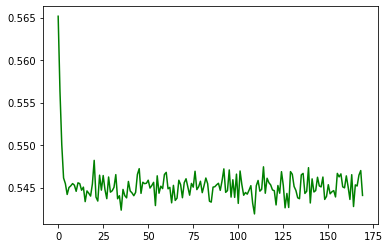

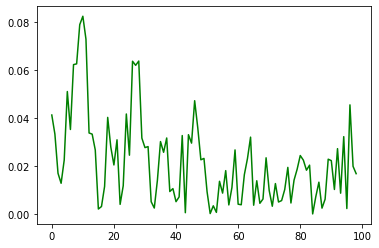

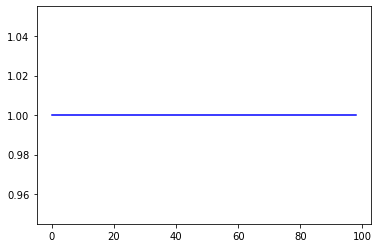

In [10]:
idx = 0

anomaly_history = []
loss_history = []
avgSum = 0
avgCount = 0

for epoch in range(epochs):
    b = get_batch(X,batch)
    #print(range(batch))
    for i in range(batch):
        #localX = torch.tensor(b[i].cuda())
        localX = to_var(torch.tensor(b[i]))
        recon, mu, logvar = demo(localX)
        loss = loss_fn(recon, localX, mu, logvar) #doing kl-divergence loss correctly
        """This bound (kl loss) provides a unified objective function for 
        op-timization of both the parameters θ and φ of the model and variational approximation, respectively."""
        optimizer.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer2.step()
        scheduler.step()
        idx = idx + 1

        avgSum = avgSum + torch.mean(loss/batch)
        avgCount = avgCount + 1
        anomaly_score = abs(torch.mean(localX-recon))

        if idx%30 == 0:
            loss_history.append(avgSum/avgCount)
            anomaly_history.append(anomaly_score)
            avgSum = 0
            avgCount = 0

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/batch))
            
p1 = plt.figure()
plt.plot(loss_history,'g-',label='h 10,z 2')


step_start = 0
anomalies = []
y_nomalies = []
county = 0
#print(type(XX))
#print(len(XX))
#print(XX.shape)
for step in t:
  step = to_var(torch.tensor(step,dtype=torch.float64))
  if True:
      #step = torch.tensor(XX[step_start:step_start+step_size])[0]
      recon,_,_ = demo(step)
      anom = abs(torch.mean(step-recon))
      anom2 = torch.mean(torch.tensor(faultNumbersTest[county*step_size:county*step_size+step_size],dtype=torch.float64))
      #if county%100 == 0:
        #print("step: " + str(step))
        #print("recon: " + str(recon))
        #print(anom)
      anomalies.append(anom)
      y_nomalies.append(anom2)
      step_start = step_start + 1
      county = county + 1

start = 0
view = []
max = -99999
min = 99999
maxA = -99999
minA = 99999

print(len(anomalies))

for a in anomalies:
    if start+1 < len(anomalies):
        view.append(abs(anomalies[start+1].item() - a.item()))  
        start = start + 1
  
for i in range(len(view)):
    j = i + 1
    if view[i] > max:
        max = a.item()
    if view[i] < min:
        min = a.item()
    if i < len(view)-1:
        #print("i: " + str(view[i]))
        #print("j: " + str(view[j]))
        v = abs(view[i]-view[j])
        #print("v: " + str(v))
        if v > maxA:
            maxA = v
        if v < minA:
            minA = v
            
print()
print(max)
print(maxA)
print(minA)

#could get loc min and max given a step size rather than literally between individual points
                
p3 = plt.figure()
plt.plot(anomalies, 'g-')
p4 = plt.figure()
plt.plot(y_nomalies, 'b-')